In [1]:
import os
import astropy
import numpy as np
from astropy.table import Table
from astropy.table import Column
import glob
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import ascii

In [2]:
dash = "C:/users/20xha/Documents/Caltech/Research/DASH/"

In [3]:
dashoutput = np.load(dash+"output.npy",allow_pickle=True)

In [4]:
snid_superfit_results = Table.read("results_2018_all_exact_z.txt", format = "ascii")

In [5]:
final_rcf_table = Table.from_pandas(pd.read_hdf("C:/users/20xha/Documents/Caltech/Research/final_rcf_table.h5"))

In [6]:
SEDM_ML_sample = Table.read("C:/Users/20xha/Documents/Caltech/Research/SEDM_ML_sample.ascii", format = "ascii")
SEDM_ML_sample.rename_column('col1', 'ZTF_Name')
SEDM_ML_sample.rename_column('col2', "Class")
SEDM_ML_sample.rename_column('col8', "Version")

In [57]:
ResultsTable_List_confidence = []
ranges = np.linspace(0.1836, 1, 101)
count = 0
ResultsTable = Table(
                names=("ZTF_Name", "Dash", "Confidence",
                ),
                meta={"name": "Spectrum Results after SNID"},
                dtype=("U64", "U64", "float64",
                      )
                )

for i in dashoutput:
    row = []
    row.append(i[-1])
    reliable = np.where(np.asarray(i[4]) != 'Unreliable matches')[0]
    if(len(reliable) != 0):
        best = np.asarray(i[2])[:,0][reliable]
        c = Counter(best)
        best_rlap = float(min(np.asarray(i[2])[:,2][reliable]))
        row.append(c.most_common()[0][0])
        row.append(best_rlap)
        ResultsTable.add_row(row)

In [60]:
ranges = np.linspace(0, 25, 6)
rlap = 0
count = 0
ResultsTable = Table(
                names=("ZTF_Name", "c_dash", "rlap_dash", "confidence_dash"
                ),
                meta={"name": "Spectrum Results after SNID"},
                dtype=("U64", "U64", "float64", "float64"
                      )
                )

for i in dashoutput:
    row = []
    row.append(i[-1])
    reliable = np.where(np.asarray(i[4]) != 'Unreliable matches')[0]
    if(len(reliable) != 0):
        best = np.asarray(i[2])[:,0][reliable]
        c = Counter(best)
        rlap_list = []
        for rlap_vals in np.asarray(i[3]):
            rlap_list.append(float(rlap_vals.split(":")[-1]))
        best_rlap = np.max(rlap_list)
        if(best_rlap > rlap):
            row.append(c.most_common()[0][0])
            row.append(best_rlap)
            best_confidence = float(min(np.asarray(i[2])[:,2][reliable]))
            row.append(best_confidence)
            ResultsTable.add_row(row)

    count += 1
if(count % 50 == 0):
    print(count)

In [62]:
all_the_power = astropy.table.join(snid_superfit_results, ResultsTable)

In [63]:
ResultsTable[0]

ZTF_Name,c_dash,rlap_dash,confidence_dash
str64,str64,float64,float64
ZTF17aaazdba,Ic-broad,1.41,0.9025


In [64]:
all_the_power[0]

ZTF_Name,classification,redshift,HGz,JD,JD_peak,phase,name,flag,is_good_spec,SF_fit_1,chi2_fit_1,zfit_1,zfit_2,SF_fit_2,chi2_fit_2,c_snid,c_rlap,z_snid,SNR,short_name,c_dash,rlap_dash,confidence_dash
str64,str9,float64,float64,float64,float64,float64,str39,int32,str5,str18,float64,float64,float64,str18,float64,str12,float64,float64,float64,str45,str64,float64,float64
ZTF18aagrdcs,Ib,0.024,0.01814,2458227.5,2458217.84,9.66,ZTF18aagrdcs_20180419_TNG_v1.ascii,1,True,Ib,0.016707946,0.024,0.024,Ca-Ib,0.018156072,Ib-norm,17.13,0.0122,22.946946461804757,2009jf/FORS2+2009-10-28 00:00:00.00,Ib-norm,3.95,0.8716


In [12]:
final_stuff = all_the_power["ZTF_Name", "classification", "c_rlap", "SF_fit_1", "c_snid", "c_dash"]

In [13]:
negativeIa = 0
positiveIa = 0
for j in final_stuff:
    correct_1a = "Ia" in j["classification"]
    if(correct_1a):
        positiveIa += 1
    if(not(correct_1a)):
        negativeIa += 1

In [22]:
tprfpr_snid = Table(
                names=("rlap_snid", "tpr_snid", "fpr_snid"
                ),
                meta={"name": "Comparison of Three Programs"},
                dtype=("float64", "float64", "float64"
                      )) 
for rlap in np.linspace(0, 25, 251):
    truepositive = [0, 0, 0]
    falsepositive = [0, 0, 0]
    for i in all_the_power:
        if(i["c_rlap"] > rlap):
            c_actual = "Ia" in i["classification"]
            
            c_snid = "Ia" in i["c_snid"]
            if(c_actual == True and c_snid == True):
                truepositive[0] += 1
            if(c_actual != True and c_snid == True):
                falsepositive[0] += 1
    row = [rlap, truepositive[0]/positiveIa, falsepositive[0]/negativeIa]
    tprfpr_snid.add_row(row)       

In [23]:
tprfpr_dash = Table(
                names=("rlap_dash", "tpr_dash", "fpr_dash"
                ),
                meta={"name": "Comparison of Three Programs"},
                dtype=("float64", "float64", "float64"
                      )) 
for rlap in np.linspace(0, 25, 251):
    truepositive = [0, 0, 0]
    falsepositive = [0, 0, 0]
    for i in all_the_power:
        if(i["confidence_dash"] > rlap):
            c_actual = "Ia" in i["classification"]
            
            c_snid = "Ia" in i["c_dash"]
            if(c_actual == True and c_snid == True):
                truepositive[0] += 1
            if(c_actual != True and c_snid == True):
                falsepositive[0] += 1
    row = [rlap, truepositive[0]/positiveIa, falsepositive[0]/negativeIa]
    tprfpr_dash.add_row(row) 

In [67]:
tprfpr_dash_everything = Table(
                names=("rlap_dash", "confidence_dash", "tpr_dash", "fpr_dash"
                ),
                meta={"name": "Comparison of Three Programs"},
                dtype=("float64", "float64", "float64", "float64"
                      )) 
for rlap in np.linspace(0, 25, 251):
    for confidence in np.linspace(0.1836, 1, 101):
        truepositive = [0, 0, 0]
        falsepositive = [0, 0, 0]
        for i in all_the_power:
            if(i["rlap_dash"] > rlap and i["confidence_dash"] > confidence):
                c_actual = "Ia" in i["classification"]

                c_snid = "Ia" in i["c_dash"]
                if(c_actual == True and c_snid == True):
                    truepositive[0] += 1
                if(c_actual != True and c_snid == True):
                    falsepositive[0] += 1
        row = [rlap, confidence, truepositive[0]/positiveIa, falsepositive[0]/negativeIa]
        tprfpr_dash_everything.add_row(row) 

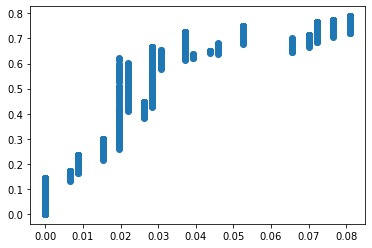

In [69]:
plt.scatter(tprfpr_dash_everything["fpr_dash"], tprfpr_dash_everything["tpr_dash"])

In [31]:
print(min(all_the_power["chi2_fit_1"]))
print(max(all_the_power["chi2_fit_1"]))

0.00033346
2.7674065


In [34]:
all_the_power[0]

ZTF_Name,classification,redshift,HGz,JD,JD_peak,phase,name,flag,is_good_spec,SF_fit_1,chi2_fit_1,zfit_1,zfit_2,SF_fit_2,chi2_fit_2,c_snid,c_rlap,z_snid,SNR,short_name,c_dash,confidence_dash
str64,str9,float64,float64,float64,float64,float64,str39,int32,str5,str18,float64,float64,float64,str18,float64,str12,float64,float64,float64,str45,str64,float64
ZTF18aagrdcs,Ib,0.024,0.01814,2458227.5,2458217.84,9.66,ZTF18aagrdcs_20180419_TNG_v1.ascii,1,True,Ib,0.016707946,0.024,0.024,Ca-Ib,0.018156072,Ib-norm,17.13,0.0122,22.946946461804757,2009jf/FORS2+2009-10-28 00:00:00.00,Ib-norm,3.95


In [46]:
tprfpr_superfit = Table(
                names=("chi2_superfit", "tpr_superfit", "fpr_superfit"
                ),
                meta={"name": "Comparison of Three Programs"},
                dtype=("float64", "float64", "float64"
                      )) 
for rlap in np.linspace(3, 0.01, 301):
    truepositive = [0, 0, 0]
    falsepositive = [0, 0, 0]
    for i in all_the_power:
        if(i["chi2_fit_1"] < rlap):
            c_actual = "Ia" in i["classification"]
            
            c_snid = "Ia" in i["SF_fit_1"]
            if(c_actual == True and c_snid == True):
                truepositive[0] += 1
            if(c_actual != True and c_snid == True):
                falsepositive[0] += 1
    row = [rlap, truepositive[0]/positiveIa, falsepositive[0]/negativeIa]
    tprfpr_superfit.add_row(row) 

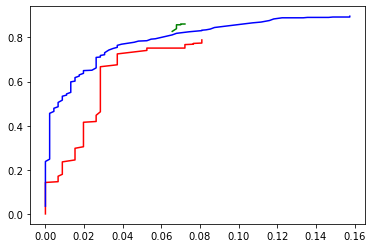

In [48]:
plt.plot(tprfpr_dash["fpr_dash"], tprfpr_dash["tpr_dash"], color = "red")
plt.plot(tprfpr_snid["fpr_snid"], tprfpr_snid["tpr_snid"], color = "blue")
plt.plot(tprfpr_superfit["fpr_superfit"], tprfpr_superfit["tpr_superfit"], color = "green")

In [50]:
ascii.write(tprfpr_snid, "tprfpr_snid.ascii")
ascii.write(tprfpr_dash, "tprfpr_dash_rlap.ascii")
ascii.write(tprfpr_superfit, "tprfpr_superfit.ascii")
ascii.write(tprfpr_superfit, "tprfpr_superfit.ascii")

In [70]:
ascii.write(tprfpr_dash_everything, "tprfpr_dash_everything.ascii")